# Loading OASIS images

See [fact sheet here](https://www.oasis-brains.org/files/oasis_cross-sectional_facts.pdf) for info on OASIS-1 dataset.

In [1]:
import glob
import os.path
oasis_dir = "/home/ebrahim/data/OASIS-1/"
image_paths = glob.glob(os.path.join(oasis_dir,'*/PROCESSED/MPRAGE/T88_111/OAS1_*_MR*_mpr_n*_anon_111_t88_masked_gfc.img'))

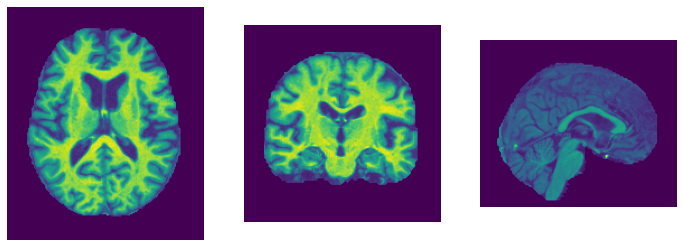

In [2]:
# Let's load one image and look at it, just to establish how we want to load these images
import random
import itk
import numpy as np
import matplotlib.pyplot as plt

# Supress the many warnings related to depracation of the Analyze file format
itk.ProcessObject.SetGlobalWarningDisplay(False) 

image_path = random.choice(image_paths)
itk_image = itk.imread(image_path)
image_array = itk.array_from_image(itk_image)

def preview_image(image_array):
    x,y,z = np.array(image_array.shape)//2 # half-way slices
    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1); plt.axis('off')
    plt.imshow(image_array[x,:,:], origin = 'lower')
    plt.subplot(1,3,2); plt.axis('off')
    plt.imshow(image_array[:,y,:], origin = 'lower')
    plt.subplot(1,3,3); plt.axis('off')
    plt.imshow(image_array[:,:,z], origin = 'lower')
    plt.show()

preview_image(image_array)

Actually, MONAI's [image loading transform](https://docs.monai.io/en/latest/transforms.html#loadimage) can already use itk!

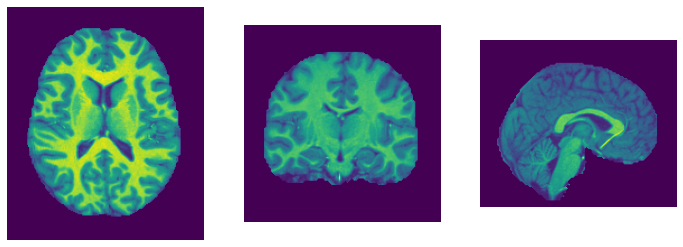

In [3]:
import monai

image_path = random.choice(image_paths)
img_itk_array = monai.transforms.LoadImage(image_only=True)(image_path)
preview_image(img_itk_array)

In [4]:
dataset = monai.data.Dataset(
    data = image_paths,
    transform = monai.transforms.Compose(
        transforms = [
            monai.transforms.LoadImage(image_only=True)
        ]
    ),
)

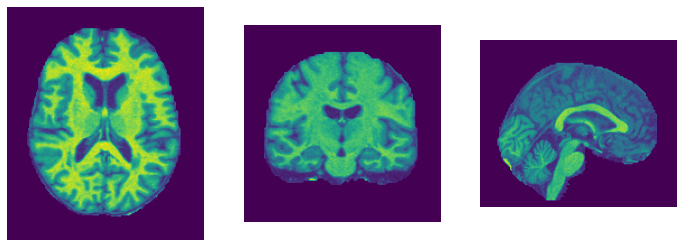

In [5]:
preview_image(dataset[17])

I think affine registration is already done for the these images, so we don't need to worry about including an affine part in the registration network. Let's look into loading a segmentation label.

Hmm, how should the data set work considering that we want to consider a general situation where some images have seg labels and some don't? 

One option: it could always return an (image,label) pair, but return `None` for the label when the segmentation isn't available. Let's try that.

In [6]:
segmentation_paths = glob.glob(os.path.join(oasis_dir,'*/FSL_SEG/OAS1_*_MR*_mpr_n*_anon_111_t88_masked_gfc_fseg.img'))

examine the segmentations provided by OASIS... what are they and how are they obtained?

In [7]:
path_to_id = lambda path : os.path.basename(path).strip('OAS1_')[:4]

seg_ids = list(map(path_to_id, segmentation_paths))
img_ids = map(path_to_id, segmentation_paths)
data = []
for img_index,img_id in enumerate(img_ids):
    seg_index = seg_ids.index(img_id) if (img_id in seg_ids) else None
    seg_path = segmentation_paths[seg_index] if (seg_index is not None) else None
    img_path = image_paths[img_index]
    data.append(
        {
            'img' : img_path,
             'seg' : seg_path
        }
    )

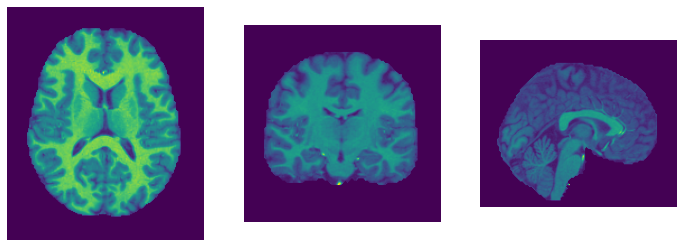

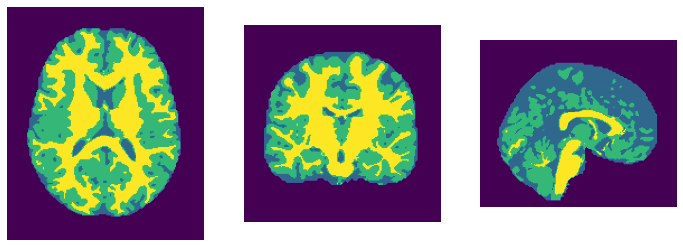

In [8]:
example_pair = monai.transforms.LoadImaged(keys=['img','seg'],image_only=True)(random.choice(data))
preview_image(example_pair['img'])
preview_image(example_pair['seg'])

So we have a segmentaton for each image. Actually, these segmentations are done by an algorithm:

*Segmentation of brain MR images through a hidden Markov random field model and the expectation maximization algorithm*\
2001 Zhang, Brady, Smith\
[link](https://pubmed.ncbi.nlm.nih.gov/11293691/)

The situation in which we'd want to apply DeepAtlas is one where we have just a handful of carefully created manual segmengations. Let's simulate this situation by pretending that some of the segmentation labels don't exist, and ignoring the fact that the segmentations we have come from an algorithm.

Next: Repeat the cell where you create `data`, but this time replace `seg_ids` with a randomly selected small-ish subset of itself. Then see if you can make `monai.transforms.LoadImaged` eat the `None`.


In [9]:
# We pretend that only a few segmentations are available.
# For all but a few items in data, we set the 'seg' to None.

num_segs_to_select = 17
random.shuffle(data)
for image_label_dict in data[:(len(data)-num_segs_to_select)]:
    image_label_dict['seg'] = None
random.shuffle(data)

Now this could be viewed as sort of a generic starting point for data to be used with DeepAtlas.
We start here with `data` being a list of dictionaries with `'img'` and `'seg'` as keys, and with the `'seg'` key often being `None`.

# Creating datasets from our data with partial labels

In [10]:
dataset_seg_available = monai.data.Dataset(
    data = list(filter(lambda d : d['seg'] is not None ,data)),
    transform = monai.transforms.Compose(
        transforms = [
            monai.transforms.LoadImageD(keys=['img','seg'], image_only=True),
            monai.transforms.ToTensorD(keys=['img','seg']),
            monai.transforms.AddChannelD(keys=['img','seg'])
        ]
    ),
)

dataset_seg_unavailable = monai.data.Dataset(
    data = list(filter(lambda d : d['seg'] is None ,data)),
    transform = monai.transforms.Compose(
        transforms = [
            monai.transforms.LoadImageD(keys=['img'], image_only=True),
            monai.transforms.ToTensorD(keys=['img']),
            monai.transforms.AddChannelD(keys=['img'])
        ]
    ),
)

Next: Create registration and segmentation models and losses as described in the paper and see that you can send the data through.

# Segmentation network and dice loss

In [11]:
# It's not the same as the paper, since the paper does maxpooling for it's seg net,
# while this UNet does convolution with stride>1 for the downsampling steps.
# Also the paper uses leaky relu activation and this uses prelu.
# Also the paper does batch norm while this does instance norm

seg_net = monai.networks.nets.UNet(
    3, # spatial dims
    1, # input channels
    4, # output channels (4 segmentation classes)
    (8,16,16,32,32,64,64), # channel sequence
    (1,2,1,2,1,2) # convolutional strides
)

In [12]:
# Try out a forward pass

# It's pretty fortunate that the OASIS images have all their spatial dimensions being multiples of 8,
# cosnidering that we downsample by a factor of 2 three time in the UNet. Very clean.

seg_net_example_output = seg_net(dataset_seg_available[0]['img'].unsqueeze(0))

In [13]:
import torch

print(torch.unique(dataset_seg_available[0]['seg'])) # segmentation classes
print(dataset_seg_available[0]['seg'].unsqueeze(0).shape) # shape of ground truth label
print(seg_net_example_output.shape) # shape of seg net output

tensor([0., 1., 2., 3.])
torch.Size([1, 1, 176, 208, 176])
torch.Size([1, 4, 176, 208, 176])


In [14]:
# Here's an example: the segmentation label and the prediction for the voxel at (128,128,128)

print(dataset_seg_available[0]['seg'][:,128,128,128])
print(torch.softmax(seg_net_example_output, dim=1)[0,:,128,128,128])

tensor([2.])
tensor([0.0390, 0.0709, 0.1789, 0.7112], grad_fn=<SelectBackward>)


In [15]:
dice_loss = monai.losses.DiceLoss(
    include_background=True, # Include background in the multiclass DICE loss: background, CSF, grey, white
    to_onehot_y=True, # Our seg labels are single channel images indicating class index, rather than one-hot
    softmax=True, # Note that our segmentation network is missing the softmax at the end
    reduction="mean" # Follows the paper
)

In [16]:
#Let's try out the dice loss on an example.
dice_loss(
    seg_net_example_output, # Prediction from seg_net
    dataset_seg_available[0]['seg'].unsqueeze(0) # Ground truth label
)

tensor(0.7046, grad_fn=<MeanBackward0>)

# Registration network and NCC loss

Do this next.

In [17]:
# Not exactly identical to the registration network in the paper, but similar
# The main difference is that this one doesn't get to the very middle step labeled 1/16
# It seems that MONAI UNet design will not stick one block in the middle like we see in fig 3 of the paper

reg_net = monai.networks.nets.UNet(
    3, # spatial dims
    2, # input channels (one for fixed image and one for moving image)
    3, # output channels (to represent 3D displacement vector field)
    (16,32,32,32,32), # channel sequence
    (1,2,2,2,2) # convolutional strides
)

In [18]:
# Try out a forward pass

fixed_image_example = dataset_seg_unavailable[0]['img'].unsqueeze(0)
moving_image_example = dataset_seg_unavailable[1]['img'].unsqueeze(0)

#Concatenate two images along channel dimension, to serve as a "fixed" and a "moving" image
reg_net_example_input = torch.cat([fixed_image_example, moving_image_example],1)
print(reg_net_example_input.shape)

reg_net_example_output = reg_net(reg_net_example_input)
print(reg_net_example_output.shape)
# The output of the reg_net is assumed to be a displacement vector field
# (so e.g. a zero output would be the identity warping)

torch.Size([1, 2, 176, 208, 176])
torch.Size([1, 3, 176, 208, 176])


In [19]:
# Local normalized cross-correlation loss.
# The paper does a global NCC, but MONAI provides local and it's easy to use.
# Another difference from the paper: instead of returning 1-LNCC this will return -LNCC

lncc_loss = monai.losses.LocalNormalizedCrossCorrelationLoss(
    ndim=3, # this keyword argument will soon be renamed to spatial_dims
    kernel_size=3,
    kernel_type='rectangular',
    reduction="mean"
)

The output of `reg_net` is a displacement field.
In order to compute the resulting image similarity loss, we must warp the moving image using the displacement field.

In [20]:
warp = monai.networks.blocks.Warp()

monai.networks.blocks.Warp: Using PyTorch native grid_sample.


In [21]:
# Construct an identity image mapping to test out warp and make sure it works the way I expect
x_dim, y_dim, z_dim = fixed_image_example[0,0].shape
x_proj = torch.tensor(range(x_dim))
x_proj = x_proj.repeat((z_dim,y_dim,1))
x_proj = x_proj.permute((2,1,0))
y_proj = torch.tensor(range(y_dim))
y_proj = y_proj.repeat((x_dim,z_dim,1))
y_proj = y_proj.permute((0,2,1))
z_proj = torch.tensor(range(z_dim))
z_proj = z_proj.repeat((x_dim,y_dim,1))
identity_map = torch.stack([x_proj,y_proj,z_proj])
identity_map = identity_map.float()
print(identity_map.shape)
identity_map[:,33,44,55] # Should be [33,44,55]

torch.Size([3, 176, 208, 176])


tensor([33., 44., 55.])

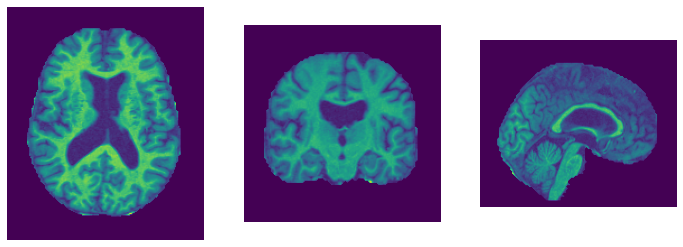

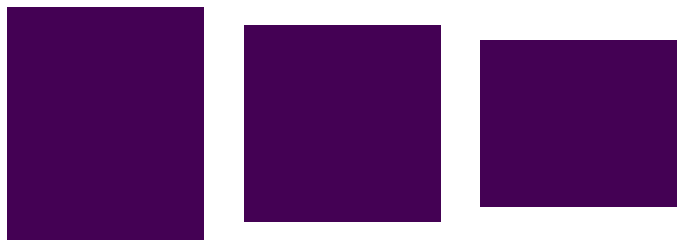

In [22]:
preview_image(moving_image_example[0,0])
preview_image(warp(moving_image_example,identity_map.unsqueeze(0))[0,0])

Hmm I see, it seems that warp is expecting a displacement vector field

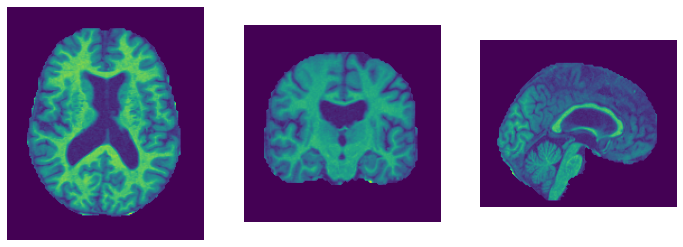

In [23]:
zero_displacement = torch.zeros((3,x_dim,y_dim,z_dim))
preview_image(warp(moving_image_example,zero_displacement.unsqueeze(0))[0,0])
# Ah okay, warp is expected a displacement vector field, not an image mapping

In [24]:
# Let's test out warping using the example reg_net output from above

example_warped_image = warp(moving_image_example, reg_net_example_output)  
print(example_warped_image.shape)

torch.Size([1, 1, 176, 208, 176])


In [25]:
# Now let's test our image similarity loss function

lncc_loss(
    example_warped_image, # prediciton
    fixed_image_example # target
)

tensor(-0.7446, grad_fn=<NegBackward>)

# Regularization: bending energy

In [26]:
bending_loss = monai.losses.BendingEnergyLoss()

print(bending_loss(zero_displacement.unsqueeze(0)))
print(bending_loss(reg_net_example_output))

tensor(0.)
tensor(1.3413, grad_fn=<MeanBackward0>)


# Preparing datasets more carefully

We are going to start by pre-training the segmentation network on the few segmentations that we have. Then we will jointly train the segmentation and the registration networks using all available image pairs. In the training loop if both images are unlabeled then we skip the learning step for the segmentation network, since there is no source of truth for it. 

During the segmentation network pretraining, we just want `dataset_seg_available` as defined above.

During the joint training, there are two important cases to care about:
- Image pairs where at least one of them has a segmentation label.
- Image pairs where neither of them have a segmentation label.

Since the second one doesn't allow for `seg_net` learning, we want these two to be separate so that we can have direct control over the relative rates of training `reg_net` vs `seg_net` (rather than let it be controlled by the proportion of images that have segmentation labels). 

# Pre-training the segmentation network

In [27]:
# Remember how we built data above? Let's redo the datasets from there

data[:2]

[{'img': '/home/ebrahim/data/OASIS-1/OAS1_0007_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0007_MR1_mpr_n3_anon_111_t88_masked_gfc.img',
  'seg': None},
 {'img': '/home/ebrahim/data/OASIS-1/OAS1_0365_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0365_MR1_mpr_n4_anon_111_t88_masked_gfc.img',
  'seg': None}]

In [28]:
data_seg_available  =  list(filter(lambda d : d['seg'] is not None ,data))
data_seg_unavailable = list(filter(lambda d : d['seg'] is None ,data))

data_seg_available_train, data_seg_available_valid = \
    monai.data.utils.partition_dataset(data_seg_available, ratios=(8,2))
# Validation of the segmentation network only makes sense if you have enough segmentation labels.
# E.g. you should definitely skip it if there's just one segmentation label.

transform_seg_available = monai.transforms.Compose(
    transforms = [
        monai.transforms.LoadImageD(keys=['img','seg'], image_only=True),
        monai.transforms.ToTensorD(keys=['img','seg']),
        monai.transforms.AddChannelD(keys=['img','seg'])
    ]
)

dataset_seg_available_train = monai.data.CacheDataset(
    data = data_seg_available_train,
    transform = transform_seg_available,
)

dataset_seg_available_valid = monai.data.CacheDataset(
    data = data_seg_available_valid,
    transform = transform_seg_available,
)

dataloader_seg_available_train = monai.data.DataLoader(
    dataset_seg_available_train,
    batch_size=1,
    num_workers=4,
    shuffle=True
)

dataloader_seg_available_valid = monai.data.DataLoader(
    dataset_seg_available_valid,
    batch_size=1,
    num_workers=4,
    shuffle=False
)

Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 424.68it/s]


In [29]:
seg_net.to('cuda')

learning_rate = 1e-4
optimizer = torch.optim.Adam(seg_net.parameters(), learning_rate)

training loss: 0.6739174766199929, validation loss: 0.6407208244005839


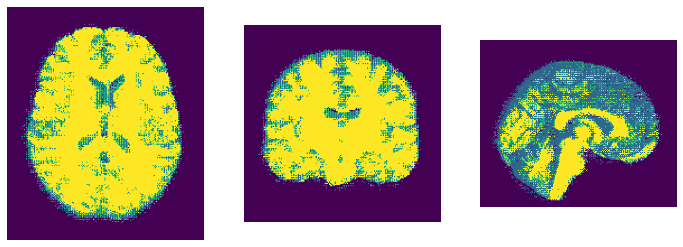

training loss: 0.6097967496940068, validation loss: 0.5779197812080383


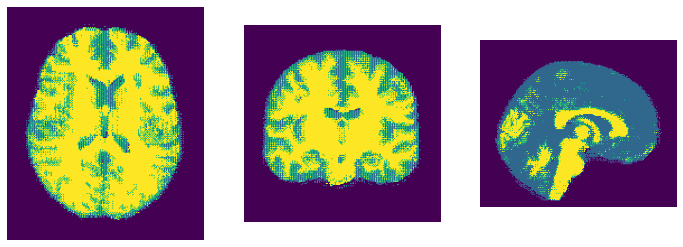

KeyboardInterrupt: 

In [30]:
# Training cell

max_epochs = 30
training_losses = []
validation_losses = []

for epoch_number in range(max_epochs):
    
    
    seg_net.train()
    losses = []
    for batch in dataloader_seg_available_train:
        imgs = batch['img'].to('cuda')
        true_segs = batch['seg'].to('cuda')

        optimizer.zero_grad()
        predicted_segs = seg_net(imgs)
        loss = dice_loss(predicted_segs, true_segs)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    
    training_loss = np.mean(losses)
    
    seg_net.eval()
    losses = []
    with torch.no_grad():
        for batch in dataloader_seg_available_valid:
            imgs = batch['img'].to('cuda')
            true_segs = batch['seg'].to('cuda')
            predicted_segs = seg_net(imgs)
            loss = dice_loss(predicted_segs, true_segs)
            losses.append(loss.item())
        validation_loss = np.mean(losses)
        
    print(f"training loss: {training_loss}, validation loss: {validation_loss}")
    preview_image(torch.argmax(torch.softmax(seg_net(dataset_seg_available_valid[0]['img'].unsqueeze(0).cuda()),dim=1),dim=1, keepdim=True)[0,0].cpu())

In [ ]:
# CHECKPOINT CELL; SAVE
# torch.save(seg_net.state_dict(),'seg_net_pretrained.pth')

In [33]:
# CHECKPOINT CELL; LOAD
seg_net.load_state_dict(torch.load('seg_net_pretrained.pth'))

<All keys matched successfully>

In [31]:
# Get seg_net out of graphics memory to make room for other things coming up next
seg_net.to('cpu');

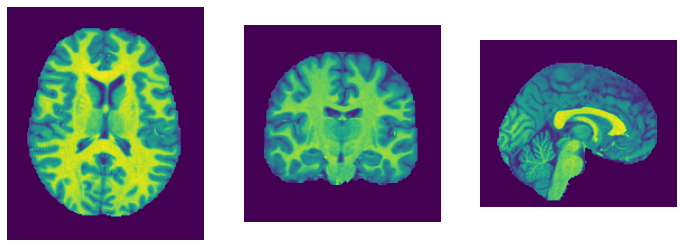

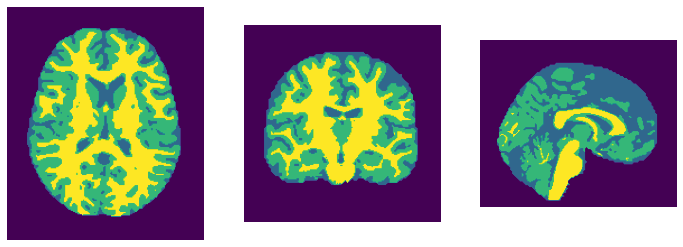

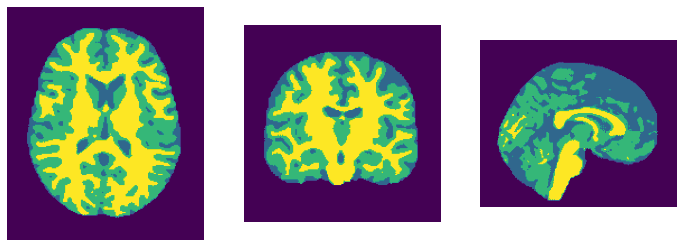

In [34]:
# Let's try out our pretrained seg net on one of the validation images

test_input = dataset_seg_available_valid[0]['img'].unsqueeze(0)
test_seg_predicted = seg_net(test_input)

# Original image from validation set
preview_image(dataset_seg_available_valid[0]['img'][0])
# Ground truth segmentation
preview_image(dataset_seg_available_valid[0]['seg'][0])
# Our predicted segmentation
seg_net.eval()
preview_image(torch.argmax(torch.softmax(seg_net(dataset_seg_available_valid[0]['img'].unsqueeze(0)),dim=1),dim=1, keepdim=True)[0,0])

# Preparing datasets for joint/alternative training

During the joint training, there are two important cases to care about:
- Image pairs where at least one of them has a segmentation label.
- Image pairs where neither of them has a segmentation label.

Since the second one doesn't allow for `seg_net` learning, we want these two to be separate so that we can have direct control over the relative rates of training `reg_net` vs `seg_net` (rather than let it be controlled by the proportion of images that have segmentation labels). 

In [64]:
# Be careful not to include any images with segmentation label that were used for seg_net validation.
# We don't want those influencing further seg_net training that is coming up
data_without_seg_valid = data_seg_unavailable + data_seg_available_train

# Image pairs where at least one of them has a segmentation label (omitting ones used to validate seg_net)
data_pairs_seg_available = []

# Image pairs where neither of them has a segmentation label
# Could be empty, but that's okay
data_pairs_seg_unavailable = []

# Randomize the initial order of this list, so that we
# are not biased in which images get to be moving and which gets to be target
# (though it shouldn't matter if we really do handle both directions in each training step)
random.shuffle(data_without_seg_valid) 

# Populate the lists
for i in range(len(data_without_seg_valid)):
    # We will not allow reverse pairs, since we plan to handle both "directions" in each training step
    # (this allows us to introduce inverse consistency loss, if we want to)
    for j in range(i):
        # The terms "moving" and "target" are arbitrary, since we do both directions in each training step
        # Might want to use different terms like "img1" and "img2".
        moving = data_without_seg_valid[i]
        target = data_without_seg_valid[j]
        pair = {
            'moving_img' : moving['img'],
            'moving_seg' : moving['seg'],
            'target_img' : target['img'],
            'target_seg' : target['seg']
        }
        if moving['seg'] is not None or target['seg'] is not None:
            data_pairs_seg_available.append(pair)
        else:
            data_pairs_seg_unavailable.append(pair)


# For validation of reg_net, we prefer not to use the precious pairs from data_pairs_seg_available,
# if that's possible. The following split tries to use data_pairs_seg_unavailable for the
# the validation set, to the extent possible.
data_pairs_valid, data_pairs_train = monai.data.utils.partition_dataset(
    data_pairs_seg_unavailable + data_pairs_seg_available, # Note the order
    ratios=(2,8), # Note the order
    shuffle = False
)


# A version of data_pairs_seg_available that consists of only training data
data_pairs_seg_available_train = []

# A version of data_pairs_seg_unavailable that consists of only training data
# Could be empty, but that's okay
data_pairs_seg_unavailable_train = []


# Populate the lists
for pair in data_pairs_train:
    if pair['moving_seg'] is not None or pair['target_seg'] is not None:
        data_pairs_seg_available_train.append(pair)
    else:
        data_pairs_seg_unavailable_train.append(pair)


print(f"We have {len(data_pairs_seg_available_train)} pairs to train reg_net and seg_net together, and an additional",
      f"{len(data_pairs_seg_unavailable_train)} to train reg_net alone.")

We have 5929 pairs to train reg_net and seg_net together, and an additional 68203 to train reg_net alone.



Next:

You need to split up the training and validation data four-ways based on where segmentations are available. This is because the transforms like LoadImageD and others do NOT like to see "None". This is starting to get ridiculus. Four datasets for training and four for validation? And a different transform chain for each one of those eight? There must be a better way. Maybe a way to make a transform pass a "None" through as "None" instead of freaking out...

Okay, I know: Define the transform you want using `Compose`, but as a regular `Transform` rather than a `MapTransform`. Then [extend](https://docs.monai.io/en/latest/transforms.html#maptransform) `MapTransform` to create something that carries out the composite transform you created but passes the `None` through as `None`. Go back and apply this strategy to the seg_net dataloader creation. Then there's no need for a four-way split here. You'll just have three data loaders in the end:
- one for validation
- one for the situation where at least one of the two images has a segmentation label
- one for the situation where neither image has a segmentation label

In [42]:
# This cell is just copied and pasted from above, to remind me what I need to do next. Don't run this cell now.

transform_seg_available = monai.transforms.Compose(
    transforms = [
        monai.transforms.LoadImageD(keys=['img','seg'], image_only=True),
        monai.transforms.ToTensorD(keys=['img','seg']),
        monai.transforms.AddChannelD(keys=['img','seg'])
    ]
)

dataset_seg_available_train = monai.data.CacheDataset(
    data = data_seg_available_train,
    transform = transform_seg_available,
)

dataset_seg_available_valid = monai.data.CacheDataset(
    data = data_seg_available_valid,
    transform = transform_seg_available,
)

dataloader_seg_available_train = monai.data.DataLoader(
    dataset_seg_available_train,
    batch_size=1,
    num_workers=4,
    shuffle=True
)

dataloader_seg_available_valid = monai.data.DataLoader(
    dataset_seg_available_valid,
    batch_size=1,
    num_workers=4,
    shuffle=False
)

86736